In [78]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.learning_curve import learning_curve
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix

# Exercise 1

## Importing and simple cleaning of data

First of all, some simple cleaning. We remove features that have nothing to do with the skin color. We remove player (we will use 'playerShort' later for aggregating), birthday, Alpha_3 (since it is the same as refCountry) and photoID.

There are missing values for height, weight and position. And also 163 dyads miss the information for the implicit association test and the explicit bias scores.

First we will remove the referees that got in the data by mistake (as mentioned in the preprocessing article) and see if the problem is solved then. After removing these referees, there were still 110 samples with missing data which we just removed.

The missing values of height and weight are replaced by the respective means and the missing values in position are replaced by the most frequently occuring position.

In [3]:
df = pd.read_csv ('CrowdstormingDataJuly1st.csv')
df.head ()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [4]:
# remove values without skin color rating (we know all samples have either two raters or none)
df_train_raw = df [pd.notnull (df ['rater1'])]

In [5]:
# drop unimportant features
df_train_raw = df_train_raw.drop(['birthday', 'player', 'Alpha_3', 'photoID'], axis=1)

In [6]:
# remove referees that are not supposed to be in here
referees_to_remove = df_train_raw.groupby('refNum').sum()[df_train_raw.groupby('refNum').sum()['games'] < 22].index.tolist()
df_train_raw = df_train_raw[~df_train_raw.refNum.isin(referees_to_remove)]

In [7]:
# remove samples that don't have IAT or Exp score information
df_train_raw = df_train_raw[df_train_raw.meanIAT.notnull()]

In [14]:
# set missing height, weight and position values to mean
mean_height = df_train_raw.height.mean()
mean_weight = df_train_raw.weight.mean()
most_frequent_position = df_train_raw['position'].value_counts().index[0]

df_train_raw.loc[df_train_raw.height.isnull(),'height'] = mean_height
df_train_raw.loc[df_train_raw.weight.isnull(),'weight'] = mean_weight
df_train_raw['position'] = df_train_raw['position'].fillna(most_frequent_position)

## Advanced pre-processing

We create a new feature called "skinColor" which is the average of both ratings, then mapped to either "white" or "black" to simplify our classification.

Position, club and leagueCountry are not numerical, we use dummy variables to make them numerical. For now we left out the club feature because it would cause a lot of dummy variables and we assume it is not a significant feature. We will check in the end if we get significantly better result if we add this feature.

We drop height and weight, as there are not features that we are looking for to influence the model.

In [15]:
df_train = df_train_raw

# create feature "skinColor"
def attribute_skin_label(val):
    if val > 0.5:
        return 1 #  "black"
    else:
        return 0  # "white"
    
#Replace rating with either white or black
df_train['skinColor'] = df_train[['rater1','rater2']].mean(axis=1).apply(attribute_skin_label)
df_train = df_train.drop(['rater1', 'rater2'], 1)

# add dummy variables for position, club and leagueCountry
n_positions = len(df_train.position.unique())
#n_club = len(df_train.club.unique())
n_leagueCountry = len(df_train.leagueCountry.unique())

d_positions = pd.get_dummies(df_train['position'])
#d_club = pd.get_dummies(df_train['club'])
d_leagueCountry = pd.get_dummies(df_train['leagueCountry'])

df_train = pd.concat([df_train, d_positions, d_leagueCountry], axis=1)
df_train = df_train.drop(['position', 'club', 'leagueCountry','height','weight'], 1)

In [53]:
# Checking how many "white" and "black" players we have
df_train['skinColor'].value_counts()

0    98033
1    18489
Name: skinColor, dtype: int64

## Player aggregation and feature engineering
We added 6 new features: the meanIAT and the meanExp per dyad are multiplied with each of the values 'redCards', 'YellowCards', and 'YellowRedCards'. We do this because the average of the meanIAT or meanExp per player is not useful. This average only tells us something about the racial bias of the countries this player has been refereed by. The most important is the influence of these referees on the number of cards he got. So the combined features.

We aggregate per player because we want to predict the skin color of a given player, not of a given dyad.

In [17]:
df_train['IATRedCards'] = df_train['redCards']*df_train['meanIAT']
df_train['ExpRedCards'] = df_train['redCards']*df_train['meanExp']
df_train['IATYellowRedCards'] = df_train['yellowReds']*df_train['meanIAT']
df_train['ExpYellowRedCards'] = df_train['yellowReds']*df_train['meanExp']
df_train['IATYellowCards'] = df_train['yellowCards']*df_train['meanIAT']
df_train['ExpYellowCards'] = df_train['yellowCards']*df_train['meanExp']

In [18]:
#df_agg = df_train.groupby('playerShort').sum().columns
summed = df_train[['playerShort','games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards']].groupby('playerShort').sum()
meaned = df_train[['playerShort', 'skinColor','Attacking Midfielder', 'Center Back', 'Center Forward',
       'Center Midfielder', 'Defensive Midfielder', 'Goalkeeper',
       'Left Fullback', 'Left Midfielder', 'Left Winger', 'Right Fullback',
       'Right Midfielder', 'Right Winger', 'England', 'France', 'Germany',
       'Spain', 'meanIAT', 'meanExp', 'IATRedCards', 'ExpRedCards', 'IATYellowRedCards', 'ExpYellowRedCards', 'IATYellowCards', 'ExpYellowCards' ]].groupby('playerShort').mean()

In [19]:
df_agg = pd.concat([summed, meaned], axis=1)

In [57]:
df_agg.head()

,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,skinColor,Attacking Midfielder,...,Germany,Spain,meanIAT,meanExp,IATRedCards,ExpRedCards,IATYellowRedCards,ExpYellowRedCards,IATYellowCards,ExpYellowCards
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,646,243,179,224,8,19,0,0,0,0.0,...,0.0,0.0,0.345236,0.489953,0.000000,0.000000,0.000000,0.000000,0.040634,0.052094
aaron-hunt,335,141,72,122,62,42,0,1,0,1.0,...,1.0,0.0,0.348943,0.450376,0.003435,0.003428,0.000000,0.000000,0.146678,0.166008
aaron-lennon,412,200,97,115,31,11,0,0,0,0.0,...,0.0,0.0,0.345893,0.491482,0.000000,0.000000,0.000000,0.000000,0.036158,0.043801
aaron-ramsey,253,144,42,67,39,31,0,1,0,0.0,...,0.0,0.0,0.347013,0.511374,0.003450,0.003465,0.000000,0.000000,0.107859,0.137232
abdelhamid-el-kaoutari,124,41,40,43,1,8,4,2,0,0.0,...,0.0,0.0,0.331600,0.335587,0.018091,0.018168,0.036675,0.039297,0.072364,0.072670


In [21]:
df_agg.columns

Index(['games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards',
       'yellowReds', 'redCards', 'skinColor', 'Attacking Midfielder',
       'Center Back', 'Center Forward', 'Center Midfielder',
       'Defensive Midfielder', 'Goalkeeper', 'Left Fullback',
       'Left Midfielder', 'Left Winger', 'Right Fullback', 'Right Midfielder',
       'Right Winger', 'England', 'France', 'Germany', 'Spain', 'meanIAT',
       'meanExp', 'IATRedCards', 'ExpRedCards', 'IATYellowRedCards',
       'ExpYellowRedCards', 'IATYellowCards', 'ExpYellowCards'],
      dtype='object')

## Making the model


### Helper functions

In [22]:
# Helper function for displaying feature importance
def feature_importance(X, features, n_most_important_features=5):
    """
    Prints the n most important features of the classifier in order
    @param X: The data matrix
    @param features: clf.feature_importances_
    @param n_most_important_features
    """
    feature_importance = {}
    for x,y in zip(X.columns,features):
        feature_importance[x]=y
    import operator
    sorted_feature_importance = sorted(feature_importance.items(), key=operator.itemgetter(1),reverse=True)
    for i in range(min(len(features),n_most_important_features)):
        print (sorted_feature_importance[i])

In [73]:
# Helper function for plotting learning curves
def plot_learning_curve(title, estimator, X, y, cv=30):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    title : string
        Title for the chart.
        
    estimator: clf

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
    """
    plt.figure()
    plt.title(title)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### Model 1: Baseline model, only based on cards

We start off with a simple model.

In [24]:
clf = RandomForestClassifier(n_estimators=10)
Y = np.asarray(df_agg['skinColor'], dtype='str')
X = df_agg[['yellowCards','yellowReds', 'redCards']]

In [25]:
X.columns  # Features in model

Index(['yellowCards', 'yellowReds', 'redCards'], dtype='object')

In [27]:
print ('Cross validation scores:')
print(cross_val_score(clf, X, Y, cv=10, scoring='accuracy'))
clf.fit(X,Y)
print('Features ranked by importance:')
feature_importance(X, clf.feature_importances_)

Cross validation scores:
[ 0.78616352  0.79874214  0.80503145  0.81132075  0.77358491  0.76582278
  0.75949367  0.7721519   0.7721519   0.76433121]
Features ranked by importance:
('yellowCards', 0.81905589569660919)
('redCards', 0.090995116372407064)
('yellowReds', 0.089948987930983784)


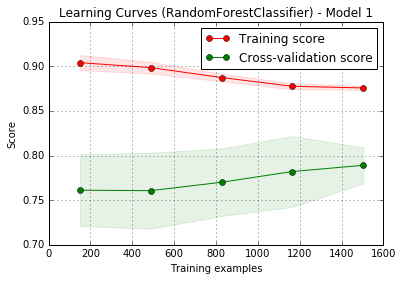

In [28]:
title = "Learning Curves (RandomForestClassifier) - Model 1"

plot_learning_curve(title, clf, X, Y)

plt.show()

### Model 2: Model with all raw data that came out of preprocessing (no combined features)

We decide to keep meanIAT and meanExp. As we have aggregated by player, the represent the average amount of bias the players receive over all the referees they meet. 

In [93]:
clf = RandomForestClassifier(n_estimators=500, max_features='log2', max_depth=8, min_samples_leaf=2)
Y = np.asarray(df_agg['skinColor'], dtype='str')
X = df_agg.drop(['skinColor','IATRedCards','ExpRedCards', 'IATYellowRedCards', 'ExpYellowRedCards','IATYellowCards', 'ExpYellowCards' ], 1)

In [94]:
X.columns  # Features in model

Index(['games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards',
       'yellowReds', 'redCards', 'Attacking Midfielder', 'Center Back',
       'Center Forward', 'Center Midfielder', 'Defensive Midfielder',
       'Goalkeeper', 'Left Fullback', 'Left Midfielder', 'Left Winger',
       'Right Fullback', 'Right Midfielder', 'Right Winger', 'England',
       'France', 'Germany', 'Spain', 'meanIAT', 'meanExp'],
      dtype='object')

In [100]:
print ('Cross validation scores:')
print(cross_val_score(clf, X, Y, cv=5, scoring='accuracy'))
clf.fit(X,Y)
print('Features ranked by importance:')
feature_importance(X, clf.feature_importances_, len(clf.feature_importances_))

Cross validation scores:
[ 0.83911672  0.83280757  0.83596215  0.84542587  0.84493671]
Features ranked by importance:
('meanExp', 0.15367082579367744)
('meanIAT', 0.14408244646622348)
('victories', 0.083835813078163263)
('France', 0.082994225570044586)
('games', 0.075397134445060993)
('defeats', 0.066603487802768729)
('goals', 0.066066423220745546)
('ties', 0.062645479242150068)
('yellowCards', 0.057744462661633598)
('Germany', 0.035318692969384606)
('redCards', 0.024089340670254127)
('Spain', 0.023561720972839255)
('yellowReds', 0.021924075831156409)
('Center Forward', 0.018165869090179834)
('England', 0.017464454660857352)
('Goalkeeper', 0.015783283259876435)
('Center Back', 0.0081057031684639465)
('Left Winger', 0.0078052370882153027)
('Right Winger', 0.0077956402891195828)
('Attacking Midfielder', 0.0067206281848114285)
('Defensive Midfielder', 0.0062306407793485284)
('Right Fullback', 0.00367846014400531)
('Left Fullback', 0.0035576853664241645)
('Left Midfielder', 0.0029017261395

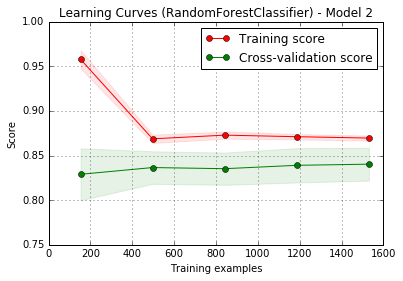

In [77]:
title = "Learning Curves (RandomForestClassifier) - Model 2"

plot_learning_curve(title, clf, X, Y)

plt.show()

### Model 3: Model with added features that multiply the meanIAT and the meanExp with the red/yellow/yellowred cards values

In [104]:
clf = RandomForestClassifier(n_estimators=500, max_features='log2', max_depth=8, min_samples_leaf=2)
Y = np.asarray(df_agg['skinColor'], dtype='str')
X = df_agg.drop(['skinColor'], 1)

In [105]:
X.columns  # Features in model

Index(['games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards',
       'yellowReds', 'redCards', 'Attacking Midfielder', 'Center Back',
       'Center Forward', 'Center Midfielder', 'Defensive Midfielder',
       'Goalkeeper', 'Left Fullback', 'Left Midfielder', 'Left Winger',
       'Right Fullback', 'Right Midfielder', 'Right Winger', 'England',
       'France', 'Germany', 'Spain', 'meanIAT', 'meanExp', 'IATRedCards',
       'ExpRedCards', 'IATYellowRedCards', 'ExpYellowRedCards',
       'IATYellowCards', 'ExpYellowCards'],
      dtype='object')

In [49]:
X.shape

(1584, 32)

In [47]:
print ('Cross validation scores:')
print(cross_val_score(clf, X, Y, cv=5, scoring='accuracy'))
clf.fit(X,Y)
print('Features ranked by importance:')
feature_importance(X, clf.feature_importances_, 20)

Cross validation scores:
[ 0.82649842  0.829653    0.84542587  0.84858044  0.84177215]
Features ranked by importance:
('meanExp', 0.10056843951851087)
('meanIAT', 0.095562009907330714)
('victories', 0.065965380510302957)
('ExpYellowCards', 0.064044805432099422)
('games', 0.063604549863979593)
('IATYellowCards', 0.062140810173221948)
('goals', 0.060092636683201958)
('defeats', 0.059533164727859994)
('ties', 0.053769585989756265)
('yellowCards', 0.052556479064876385)
('ExpRedCards', 0.037567862399713839)
('France', 0.034785081331434563)
('IATRedCards', 0.03466779785513819)
('ExpYellowRedCards', 0.03401729982388832)
('IATYellowRedCards', 0.032990495250392826)
('Germany', 0.01904928577928278)
('redCards', 0.016347745490874498)
('yellowReds', 0.015222790429740738)
('Center Forward', 0.012803152638033385)
('Spain', 0.011466313347897017)


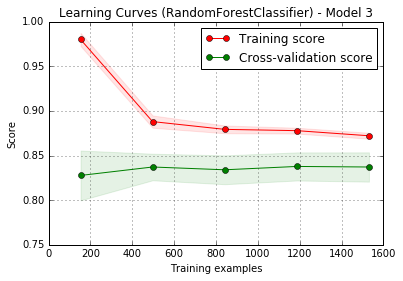

In [106]:
title = "Learning Curves (RandomForestClassifier) - Model 3"

plot_learning_curve(title, clf, X, Y)

plt.show()

### Conclusions:

By simply taking the cards as input data, we are able to make a pretty good prediction as to the skin color of the player (Model 1). This could lead to the conclusion that racial bias is a significant factor.

By including data on the the racial biases of the referees (depending on the country they come from), we are able to improve the model by about 5 percentage points. This seems reasonable because this should influence the way referees give out the cards to different to people of different color. We also notice that the new features in model 2 reduce the overfitting because the test curve and training curve approach each other more (compared to model 1) when adding more samples.

In the third model, we fine-tune even more the features. We get a better result when using fewer training examples. But as we use more data, the result is about the same as model 2.

Concerning the feature importance we see in model 1 that yellow cards have the greatest importance. Since giving a red card is a very strong decision it will be influenced less by racial bias. Whereas giving a yellow card is more 

# Exercise 2

## KMeans clustering

### Model 1: nothing dropped

In [89]:
X = df_agg.drop(['skinColor'], 1)

kmeans = KMeans(n_clusters=2, init='k-means++').fit(X)
mixed_perc = abs(df_agg['skinColor'] - kmeans.labels_).sum()/df_agg.shape[0]
print("mixed percentage: ", mixed_perc)
print("silhouette score: ", silhouette_score(X, kmeans.labels_, metric='euclidean'))

mixed percentage:  0.5940656565656566
silhouette score:  0.544592258315


### Model 2: everything dropped, except for the cards and the IAT and Exp scores

In [64]:
X = df_agg.drop(['skinColor', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'Attacking Midfielder', 'Center Back',
       'Center Forward', 'Center Midfielder', 'Defensive Midfielder',
       'Goalkeeper', 'Left Fullback', 'Left Midfielder', 'Left Winger',
       'Right Fullback', 'Right Midfielder', 'Right Winger', 'England',
       'France', 'Germany', 'Spain'], 1)

kmeans = KMeans(n_clusters=2, init='k-means++').fit(X)
mixed_perc = abs(df_agg['skinColor'] - kmeans.labels_).sum()/df_agg.shape[0]
print("mixed percentage: ", mixed_perc)
print("silhouette score: ", silhouette_score(X, kmeans.labels_, metric='euclidean'))

mixed percentage:  0.287878787879
silhouette score:  0.565120152792


### Model 3: everything dropped, except for the combined IAT/Exp + cards scores

In [65]:
X = df_agg.drop(['skinColor','games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards',
       'yellowReds', 'redCards', 'Attacking Midfielder', 'Center Back',
       'Center Forward', 'Center Midfielder', 'Defensive Midfielder',
       'Goalkeeper', 'Left Fullback', 'Left Midfielder', 'Left Winger',
       'Right Fullback', 'Right Midfielder', 'Right Winger', 'England',
       'France', 'Germany', 'Spain', 'meanIAT', 'meanExp'], 1)

kmeans = KMeans(n_clusters=2, init='k-means++').fit(X)
mixed_perc = abs(df_agg['skinColor'] - kmeans.labels_).sum()/df_agg.shape[0]
print("mixed percentage: ", mixed_perc)
print("silhouette score: ", silhouette_score(X, kmeans.labels_, metric='euclidean'))

mixed percentage:  0.325757575758
silhouette score:  0.639362322507


### Model 4: cluster by position (defense/attacker?), keeping goals and the cards?

In [88]:
X = df_agg.drop(['skinColor','games', 'victories', 'ties', 'defeats', 'Attacking Midfielder', 'Center Back',
       'Center Forward', 'Center Midfielder', 'Defensive Midfielder',
       'Goalkeeper', 'Left Fullback', 'Left Midfielder', 'Left Winger',
       'Right Fullback', 'Right Midfielder', 'Right Winger', 'England',
       'France', 'Germany', 'Spain', 'meanIAT', 'meanExp', 'IATRedCards',
       'ExpRedCards', 'IATYellowRedCards', 'ExpYellowRedCards',
       'IATYellowCards', 'ExpYellowCards'], 1)

kmeans = KMeans(n_clusters=2, init='k-means++').fit(X)
mixed_perc = abs(df_agg['skinColor'] - kmeans.labels_).sum()/df_agg.shape[0]
print("mixed percentage: ", mixed_perc)
print("silhouette score: ", silhouette_score(X, kmeans.labels_, metric='euclidean'))

mixed percentage:  0.2316919191919192
silhouette score:  0.637055592709


### Dropping columns one by one

In [101]:
drop_order = ['meanExp','meanIAT','victories','France','games','defeats','goals','ties','yellowCards','Germany','redCards','Spain','yellowReds','Center Forward','England','Goalkeeper','Center Back','Left Winger','Right Winger','Attacking Midfielder','Defensive Midfielder','Right Fullback','Left Fullback','Left Midfielder', 'Right Midfielder', 'Center Midfielder']

In [102]:
def silhouette_score_drop(df, c_drop):
    while len(c_drop) > 0:
        print("Dropped: ", c_drop)
        kmeans = KMeans(n_clusters=2, init='k-means++').fit(df[c_drop])
        mixed_perc = abs(df['skinColor'] - kmeans.labels_).sum()/df.shape[0]
        c_drop = c_drop[1:]
        print("Mixed percentage: ", mixed_perc)
        print("Silhouette score: ", silhouette_score(df[c_drop], kmeans.labels_, metric='euclidean'))
        print("Confusion matrix: ", confusion_matrix(df['skinColor'], kmeans.labels_ ))
        print("------------------------------------------------")

In [103]:
silhouette_score_drop(df_agg, drop_order)

Dropped:  ['meanExp', 'meanIAT', 'victories', 'France', 'games', 'defeats', 'goals', 'ties', 'yellowCards', 'Germany', 'redCards', 'Spain', 'yellowReds', 'Center Forward', 'England', 'Goalkeeper', 'Center Back', 'Left Winger', 'Right Winger', 'Attacking Midfielder', 'Defensive Midfielder', 'Right Fullback', 'Left Fullback', 'Left Midfielder', 'Right Midfielder', 'Center Midfielder']
Mixed percentage:  0.5940656565656566
Silhouette score:  0.544593629166
Confusion matrix:  [[447 868]
 [ 73 196]]
------------------------------------------------
Dropped:  ['meanIAT', 'victories', 'France', 'games', 'defeats', 'goals', 'ties', 'yellowCards', 'Germany', 'redCards', 'Spain', 'yellowReds', 'Center Forward', 'England', 'Goalkeeper', 'Center Back', 'Left Winger', 'Right Winger', 'Attacking Midfielder', 'Defensive Midfielder', 'Right Fullback', 'Left Fullback', 'Left Midfielder', 'Right Midfielder', 'Center Midfielder']
Mixed percentage:  0.4059343434343434
Silhouette score:  0.544593635407
Conf

ValueError: Found array with 0 feature(s) (shape=(1584, 0)) while a minimum of 1 is required.

In [98]:
feature_importance(X, clf.feature_importances_)
X

('meanExp', 0.16025178452173586)
('meanIAT', 0.14188890195125181)
('France', 0.083192660224346932)
('victories', 0.079119608646435691)
('games', 0.07438289029664423)


,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,Attacking Midfielder,Center Back,...,Left Winger,Right Fullback,Right Midfielder,Right Winger,England,France,Germany,Spain,meanIAT,meanExp
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,646,243,179,224,8,19,0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.345236,0.489953
aaron-hunt,335,141,72,122,62,42,0,1,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.348943,0.450376
aaron-lennon,412,200,97,115,31,11,0,0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.345893,0.491482
aaron-ramsey,253,144,42,67,39,31,0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.347013,0.511374
abdelhamid-el-kaoutari,124,41,40,43,1,8,4,2,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.331600,0.335587
abdou-traore_2,95,40,23,32,3,11,1,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.333336,0.339765
abdoulaye-diallo_2,22,7,7,8,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.342396,0.408009
abdoulaye-keita_2,3,0,1,2,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.355406,0.417225
abdoulwhaid-sissoko,121,34,25,62,3,21,0,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.348178,0.429630
